# Best Practices

As with all software, VerticaPy has a performance cost. To get the best performance, we need to understand the architectures of Vertica and VerticaPy. In this lesson, we'll go through some optimization steps.

## 1. Optimize your architecture at the database-level

At the end of the day, VerticaPy is an abstraction of SQL, so any database-level optimizations you make carry over to VerticaPy.

Optimizing Vertica mostly comes down to optimizing projections. Think in advance about your data architecture before creating a vDataFrame so we only select the essential columns.

In the following example, we use the 'usecols' parameter of the vDataFrame to select the most essential columns in our dataset.

None   pclass    survived     age  
1           1           0     2.0  
2           1           0    30.0  
3           1           0    25.0  
4           1           0    39.0  
5           1           0    71.0  
6           1           0    47.0  
7           1           0    None  
8           1           0    24.0  
9           1           0    36.0  
10          1           0    25.0  
11          1           0    45.0  
12          1           0    42.0  
13          1           0    41.0  
14          1           0    48.0  
15          1           0    None  
16          1           0    45.0  
17          1           0    None  
18          1           0    33.0  
19          1           0    28.0  
20          1           0    17.0  
21          1           0    49.0  
22          1           0    36.0  
23          1           0    46.0  
24          1           0    None  
25          1           0    27.0  
26          1           0    None  
27          1           0    47.0  
28          1           0    37.0  
29          1           0    None  
30          1           0    70.0  
31          1           0    39.0  
32          1           0    31.0  
33          1           0    50.0  
34          1           0    39.0  
35          1           0    36.0  
36          1           0    None  
37          1           0    30.0  
38          1           0    19.0  
39          1           0    64.0  
40          1           0    None  
41          1           0    None  
42          1           0    37.0  
43          1           0    47.0  
44          1           0    24.0  
45          1           0    71.0  
46          1           0    38.0  
47          1           0    46.0  
48          1           0    None  
49          1           0    45.0  
50          1           0    40.0  
51          1           0    55.0  
52          1           0    42.0  
53          1           0    None  
54          1           0    55.0  
55          1           0    42.0  
56          1           0    None  
57          1           0    50.0  
58          1           0    46.0  
59          1           0    50.0  
60          1           0    32.5  
61          1           0    58.0  
62          1           0    41.0  
63          1           0    None  
64          1           0    None  
65          1           0    29.0  
66          1           0    30.0  
67          1           0    30.0  
68          1           0    19.0  
69          1           0    46.0  
70          1           0    54.0  
71          1           0    28.0  
72          1           0    65.0  
73          1           0    44.0  
74          1           0    55.0  
75          1           0    47.0  
76          1           0    37.0  
77          1           0    58.0  
78          1           0    64.0  
79          1           0    65.0  
80          1           0    28.5  
81          1           0    None  
82          1           0    45.5  
83          1           0    23.0  
84          1           0    29.0  
85          1           0    18.0  
86          1           0    47.0  
87          1           0    38.0  
88          1           0    22.0  
89          1           0    None  
90          1           0    31.0  
91          1           0    None  
92          1           0    36.0  
93          1           0    55.0  
94          1           0    33.0  
95          1           0    61.0  
96          1           0    50.0  
97          1           0    56.0  
98          1           0    56.0  
99          1           0    24.0  
100         1           0    None  
Rows: 1-100 | Columns: 3
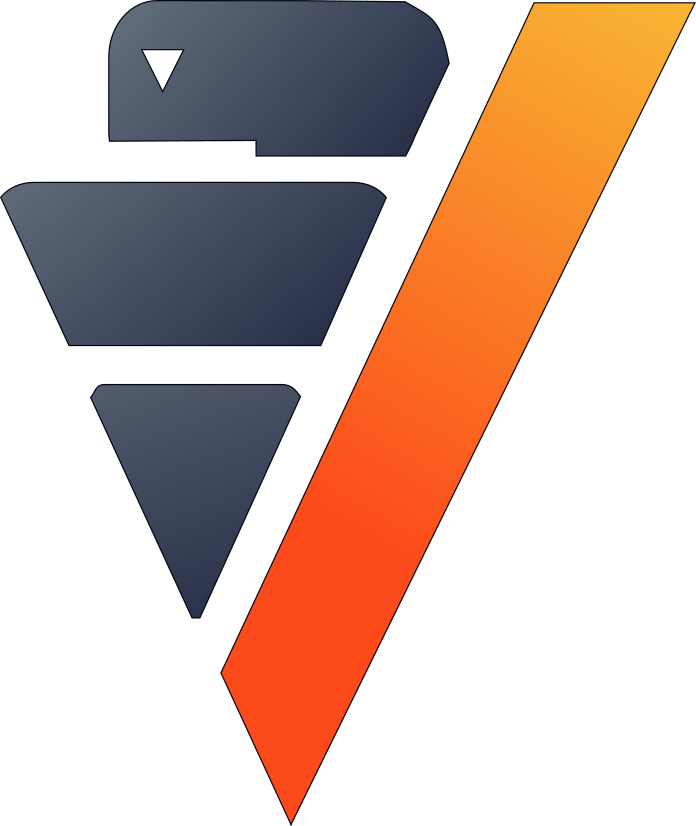

In [1]:
import verticapy as vp
from verticapy.datasets import load_titanic
load_titanic() # loading the dataset in Vertica in case we do not have it
vdf = vp.vDataFrame("public.titanic",
                    usecols = ["survived", "pclass", "age"])
display(vdf)

## 2. Save the current relation when you can

The vDataFrame works just like a view. If the final generated relation uses a lot of different functions, it will drastically increase the computation time for each method call.

Smaller transformations won't slow down the process much, but heavier transformations (multiple joins, heavy use of advanced analytical funcions, moving windows, etc.) can cause noticeable slowdown. If you make these kinds of changes, you should save the vDataFrame structure. Let's look at an example.

In [2]:
# Doing multiple operation
vdf = vp.vDataFrame("public.titanic")
vdf["sex"].label_encode()["boat"].fillna(method = "0ifnull")["name"].str_extract(
    ' ([A-Za-z]+)\.').eval("family_size", expr = "parch + sibsp + 1").drop(
    columns = ["cabin", "body", "ticket", "home.dest"])["fare"].fill_outliers().fillna()
print(vdf.current_relation())

795 elements were filled.
(
   SELECT
     "pclass",
     "survived",
     "name",
     "sex",
     "age",
     "sibsp",
     "parch",
     COALESCE("fare", 32.9113074018842) AS "fare",
     "embarked",
     "boat",
     "family_size" 
   FROM
 (
   SELECT
     "pclass",
     "survived",
     REGEXP_SUBSTR("name", ' ([A-Za-z]+)\.') AS "name",
     DECODE("sex", 'female', 0, 'male', 1, 2) AS "sex",
     COALESCE("age", 30.1524573721163) AS "age",
     "sibsp",
     "parch",
     (CASE WHEN "fare" < -176.6204982585513 THEN -176.6204982585513 WHEN "fare" > 244.5480856064831 THEN 244.5480856064831 ELSE "fare" END) AS "fare",
     COALESCE("embarked", 'S') AS "embarked",
     DECODE("boat", NULL, 0, 1) AS "boat",
     parch + sibsp + 1 AS "family_size" 
   FROM
 (
                
   SELECT
     
                    "pclass",
     "survived",
     "name",
     "sex",
     "age",
     "sibsp",
     "parch",
     "fare",
     "embarked",
     "boat" 
                
   FROM
 "public"."titani

We can look at the query plan of the new relation. This will help us understand how Vertica will execute the different aggregations.

In [3]:
print(vdf.explain())

------------------------------ 
QUERY PLAN DESCRIPTION: 

EXPLAIN SELECT /*+LABEL('vDataframe.explain')*/ * FROM (SELECT "pclass", "survived", "name", "sex", "age", "sibsp", "parch", COALESCE("fare", 32.9113074018842) AS "fare", "embarked", "boat", "family_size" FROM (SELECT "pclass", "survived", REGEXP_SUBSTR("name", ' ([A-Za-z]+)\.') AS "name", DECODE("sex", 'female', 0, 'male', 1, 2) AS "sex", COALESCE("age", 30.1524573721163) AS "age", "sibsp", "parch", (CASE WHEN "fare" < -176.6204982585513 THEN -176.6204982585513 WHEN "fare" > 244.5480856064831 THEN 244.5480856064831 ELSE "fare" END) AS "fare", COALESCE("embarked", 'S') AS "embarked", DECODE("boat", NULL, 0, 1) AS "boat", parch + sibsp + 1 AS "family_size" FROM ( SELECT "pclass", "survived", "name", "sex", "age", "sibsp", "parch", "fare", "embarked", "boat" FROM "public"."titanic") VERTICAPY_SUBTABLE) VERTICAPY_SUBTABLE) VERTICAPY_SUBTABLE

Access Path:
+-STORAGE ACCESS for titanic [Cost: 67, Rows: 1K (NO STATISTICS)] (PATH ID: 1

We did plenty of operations and we must keep in mind that each method call will use this relation for its computations. We can save the result as a table in the Vertica database and use the parameter 'inplace' to change the current relation of the vDataFrame by the new one.

In [4]:
vp.drop("public.titanic_clean", method = "table")
vdf.to_db("public.titanic_clean",
          relation_type = "table",
          inplace = True)
print(vdf.current_relation())

"public"."titanic_clean"


When we're dealing with very large datasets, we have to think a bit before saving some transformations. Ideally, you'll want to do a proper data exploration first and then perform the heavier transformations only when they're really neeed. 

## 3. Stick to essential columns

Columnar databases perform faster queries when there are fewer columns. Since Vertica is a columnar MPP database, so it's important to understand that most of the optimizations are made in projections. VerticaPy doesn't manage this part, so it's important that the data you're working with is well-organized, particularly for larger volumes of data.

Most vDataFrame methods will automatically pick up all numerical columns - even if doing so has a significant performance impact - so it's important to be a little picky and only select the essential columns for any given use case. Let's look at an example.

None                          avg  
"pclass"         2.28444084278768  
"survived"      0.364667747163695  
"age"            30.1524573721163  
"sibsp"         0.504051863857374  
"parch"         0.378444084278768  
"fare"           33.9637936739659  
"body"            164.14406779661  
Rows: 1-7 | Columns: 2
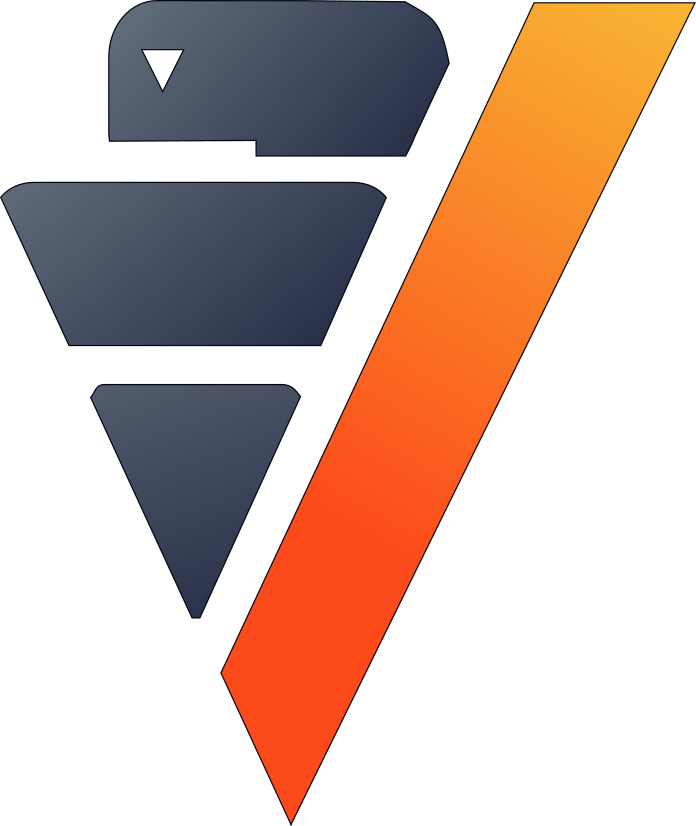

In [5]:
vdf = vp.vDataFrame("public.titanic")
vp.set_option("sql_on", True)
vdf.avg()

Here, we didn't use the 'columns' parameter to pick on any specific columns, so we ended up computing the average of all the numerical columns of the vDataFrame. This isn't a big deal when we're dealing with smaller volumes of data (less than a TB), but with larger volumes of data, we have to be more careful with which columns we use.

None                          avg  
"age"            30.1524573721163  
"survived"      0.364667747163695  
Rows: 1-2 | Columns: 2
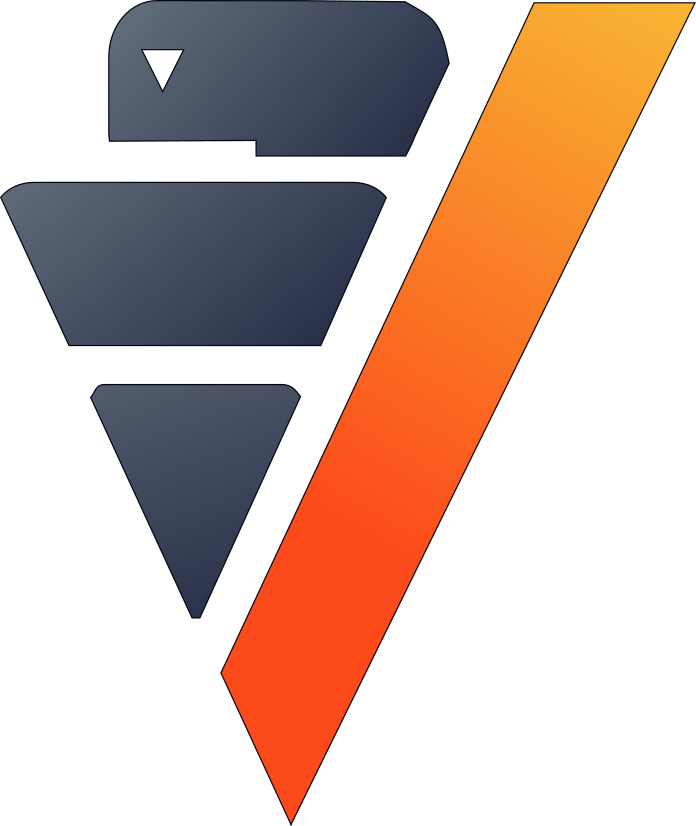

In [6]:
vdf.avg(columns = ["age", "survived"])

If you just want to exclude a few columns, you can simply get a list of all the columns and specify the unwanted columns with the 'get_columns' method.

In [7]:
vdf.get_columns()

['"pclass"',
 '"survived"',
 '"name"',
 '"sex"',
 '"age"',
 '"sibsp"',
 '"parch"',
 '"ticket"',
 '"fare"',
 '"cabin"',
 '"embarked"',
 '"boat"',
 '"body"',
 '"home.dest"']

In [8]:
vdf.get_columns(exclude_columns = ["boat", "embarked"])

['"pclass"',
 '"survived"',
 '"name"',
 '"sex"',
 '"age"',
 '"sibsp"',
 '"parch"',
 '"ticket"',
 '"fare"',
 '"cabin"',
 '"body"',
 '"home.dest"']

If you only want numerical columns, you can use the 'numcol'. This works the same way as 'get_columns', so you can also exclude columns in the same way.

In [9]:
vdf.numcol()

['"pclass"', '"survived"', '"age"', '"sibsp"', '"parch"', '"fare"', '"body"']

In [10]:
vdf.numcol(exclude_columns = ["body", "sibsp"])

['"pclass"', '"survived"', '"age"', '"parch"', '"fare"']

Let's compute a correlation matrix of our numerical columns excluding 'body' and 'sibsp'.

In [11]:
vp.set_option("plotting_lib","highcharts")
vdf.corr(columns = vdf.numcol(exclude_columns = ["parch", "sibsp"]))

Let's turn off the SQL code generation.

In [12]:
vp.set_option("sql_on", False)

## 4. Use the help function

The 'help' function is very useful for quickly viewing parameters.

In [13]:
help(vdf.agg)

Help on method aggregate in module verticapy.core.vdataframe._aggregate:

aggregate(func: Annotated[Union[str, list[str], ForwardRef('StringSQL'), list['StringSQL']], ''], columns: Optional[Annotated[Union[str, list[str]], 'STRING representing one column or a list of columns']] = None, ncols_block: int = 20, processes: int = 1) -> verticapy.core.tablesample.base.TableSample method of verticapy.core.vdataframe.base.vDataFrame instance
    Aggregates the vDataFrame using the input functions.
    
    Parameters
    ----------
    func: SQLExpression
        | List of the different aggregations:
    
        |    **aad**: average absolute deviation
        |    **approx_median**: approximate median
        |    **approx_q%**: approximate q quantile
                            (ex: approx_50% for the
                            approximate median)
        |    **approx_unique**: approximative cardinality
        |    **count**: number of non-missing elements
        |    **cvar**: conditio

## 5. Close your connections

More connections to the database will increase the concurrency on the system, so try to close all of your connections after using them. VerticaPy simplifies the connection process by allowing the user to create an auto-connection, but it will not close it until you use the 'close_connection' function.

To demonstrate, let's create a database connection. Once we're done, we'll close it.

In [14]:
import verticapy as vp
# vp.connect("VerticaDSN")

We can use it to create a vDataFrame perform some operations on the data.

795 elements were filled.


None   pclass    survived          name    sex                 age   \\
1           1           0         Miss.      0                 2.0   \\
2           1           0           Mr.      1                30.0   \\
3           1           0          Mrs.      0                25.0   \\
4           1           0           Mr.      1                39.0   \\
5           1           0           Mr.      1                71.0   \\
6           1           0          Col.      1                47.0   \\
7           1           0           Mr.      1    30.1524573721163   \\
8           1           0           Mr.      1                24.0   \\
9           1           0           Mr.      1                36.0   \\
10          1           0           Mr.      1                25.0   \\
11          1           0           Mr.      1                45.0   \\
12          1           0           Mr.      1                42.0   \\
13          1           0           Mr.      1                41.0   \\
14          1           0           Mr.      1                48.0   \\
15          1           0           Dr.      1    30.1524573721163   \\
16          1           0        Major.      1                45.0   \\
17          1           0           Mr.      1    30.1524573721163   \\
18          1           0           Mr.      1                33.0   \\
19          1           0           Mr.      1                28.0   \\
20          1           0           Mr.      1                17.0   \\
21          1           0           Mr.      1                49.0   \\
22          1           0           Mr.      1                36.0   \\
23          1           0           Mr.      1                46.0   \\
24          1           0           Mr.      1    30.1524573721163   \\
25          1           0           Mr.      1                27.0   \\
26          1           0           Mr.      1    30.1524573721163   \\
27          1           0           Mr.      1                47.0   \\
28          1           0           Mr.      1                37.0   \\
29          1           0           Mr.      1    30.1524573721163   \\
30          1           0         Capt.      1                70.0   \\
31          1           0           Mr.      1                39.0   \\
32          1           0           Mr.      1                31.0   \\
33          1           0           Mr.      1                50.0   \\
34          1           0           Mr.      1                39.0   \\
35          1           0         Miss.      0                36.0   \\
36          1           0           Mr.      1    30.1524573721163   \\
37          1           0           Mr.      1                30.0   \\
38          1           0           Mr.      1                19.0   \\
39          1           0           Mr.      1                64.0   \\
40          1           0           Mr.      1    30.1524573721163   \\
41          1           0           Mr.      1    30.1524573721163   \\
42          1           0           Mr.      1                37.0   \\
43          1           0           Mr.      1                47.0   \\
44          1           0           Mr.      1                24.0   \\
45          1           0           Mr.      1                71.0   \\
46          1           0           Mr.      1                38.0   \\
47          1           0           Mr.      1                46.0   \\
48          1           0           Mr.      1    30.1524573721163   \\
49          1           0           Mr.      1                45.0   \\
50          1           0           Mr.      1                40.0   \\
51          1           0           Mr.      1                55.0   \\
52          1           0           Mr.      1                42.0   \\
53          1           0           Mr.      1    30.1524573721163   \\
54          1           0           Mr.      1                55.0   \\
55          1           0           Mr. 
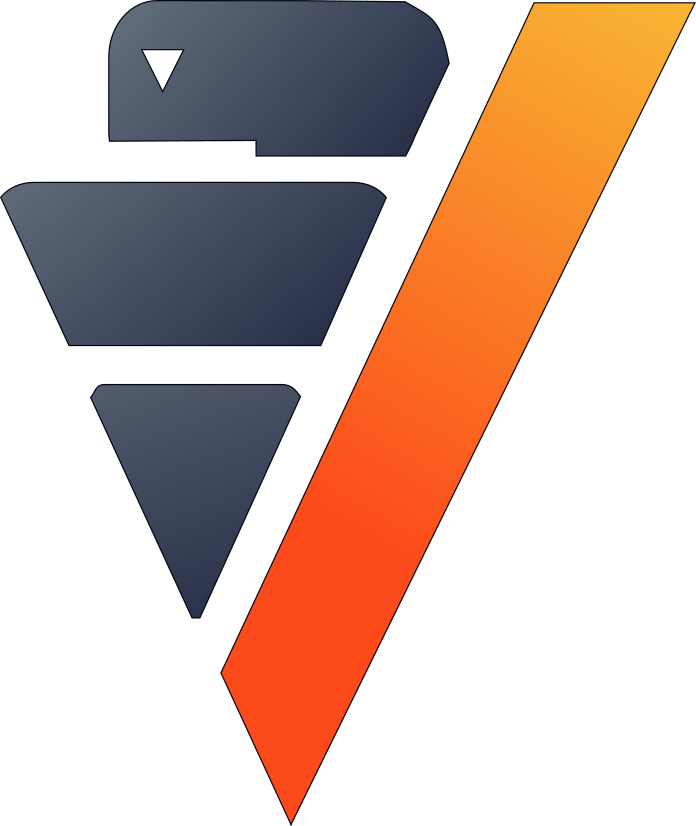

In [15]:
vdf = vp.vDataFrame("public.titanic")
vdf["sex"].label_encode()["boat"].fillna(method = "0ifnull")["name"].str_extract(
    ' ([A-Za-z]+)\.').eval("family_size", expr = "parch + sibsp + 1").drop(
    columns = ["cabin", "body", "ticket", "home.dest"])["fare"].fill_outliers().fillna()

We can then close the connection when we are done.

In [16]:
# vp.close_connection()

It is very important to follow the previous process when you are working in an environment with multiple users.

## 6. Understand the time complexity of methods

Some techniques are more computationally expensive than others. For example, a 'kendall' correlation is very expensive compared to a 'pearson' correlation. This is because a 'kendall' correlation uses a cross join, giving it a time complexity of O(n*n) (where 'n' is the number of rows). We'll demonstrate this with the 'titanic' dataset.

In [17]:
import time
vdf = vp.vDataFrame("public.titanic")
start_time = time.time()
x = vdf.corr(method = "pearson", show = False)
print("Pearson, time: {0}".format(time.time() - start_time))
start_time = time.time()
x = vdf.corr(method = "kendall", show = False)
print("Kendall, time: {0}".format(time.time() - start_time))

Pearson, time: 0.03157639503479004


  0%|          | 0/6 [00:00<?, ?it/s]

Kendall, time: 3.26833176612854


As you can see, a Kendall Correlation Matrix is noticeably slower (around 100 times more than Pearson) because of its time complexity. Keep this in mind when using methods on larger datasets.

## 7. Limit the number of elements in a plot

Graphics are a powerful way to understand data, but graphs can be difficult to parse if it has too many elements. Let's draw a multi-histogram where one column is categorical with thousands of categories.

In [18]:
vdf.bar(["name", "survived"])

VerticaPy will try to draw it, but it could take time with a large dataset. Worse, it might be completely incomprehensible. Instead, we should try to create graphics with as few categories as possible.

In [19]:
vdf.hist(["pclass", "survived"])

Try to always check the cardinality of your variables before creating graphics.

None             approx_unique  
"pclass"                   3.0  
"survived"                 2.0  
"name"                  1233.0  
"sex"                      2.0  
"age"                     96.0  
"sibsp"                    7.0  
"parch"                    8.0  
"ticket"                 888.0  
"fare"                   275.0  
"cabin"                  181.0  
"embarked"                 3.0  
"boat"                    26.0  
"body"                   118.0  
"home.dest"              355.0  
Rows: 1-14 | Columns: 2
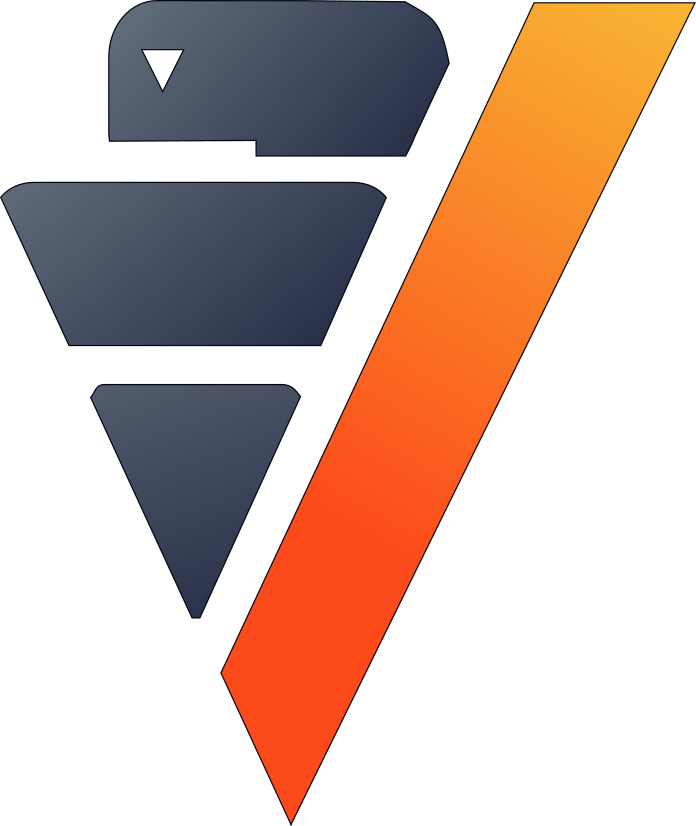

In [20]:
vdf.nunique()

## 8. Filter unneeded data

Filtering should be the first action you perform when you prepare your data. Proper filtering will help you avoid unnecessary computation and therefore drastically improve the performance of every method you call. While the performance impact isn't as important for small datasets, when working with large ones, you'll always want to filter your data in some way.

In the following example, our goal is to analyze the passengers on the Titanic that didn't have a lifeboat. Since we aren't concerned at all with passengers with a lifeboat, we can simply filter them out of the dataset and move on from there.

795 elements were filtered.


None   pclass    survived                                      name   \\
1           1           0                      Beattie, Mr. Thomson   \\
2           1           0                  Hoyt, Mr. William Fisher   \\
3           1           1             Allen, Miss. Elisabeth Walton   \\
4           1           1            Allison, Master. Hudson Trevor   \\
5           1           1                       Anderson, Mr. Harry   \\
6           1           1         Andrews, Miss. Kornelia Theodosia   \\
7           1           1  Appleton, Mrs. Edward Dale (Charlotte...   \\
8           1           1  Astor, Mrs. John Jacob (Madeleine Tal...   \\
9           1           1             Aubart, Mme. Leontine Pauline   \\
10          1           1      Barkworth, Mr. Algernon Henry Wilson   \\
11          1           1  Baxter, Mrs. James (Helene DeLaudenie...   \\
12          1           1                     Bazzani, Miss. Albina   \\
13          1           1             Beckwith, Mr. Richard Leonard   \\
14          1           1  Beckwith, Mrs. Richard Leonard (Salli...   \\
15          1           1                     Behr, Mr. Karl Howell   \\
16          1           1                     Bidois, Miss. Rosalie   \\
17          1           1                         Bird, Miss. Ellen   \\
18          1           1                   Bishop, Mr. Dickinson H   \\
19          1           1   Bishop, Mrs. Dickinson H (Helen Walton)   \\
20          1           1                    Bissette, Miss. Amelia   \\
21          1           1  Bjornstrom-Steffansson, Mr. Mauritz H...   \\
22          1           1                          Blank, Mr. Henry   \\
23          1           1                   Bonnell, Miss. Caroline   \\
24          1           1                  Bonnell, Miss. Elizabeth   \\
25          1           1                  Bowen, Miss. Grace Scott   \\
26          1           1               Bowerman, Miss. Elsie Edith   \\
27          1           1  Brown, Mrs. James Joseph (Margaret To...   \\
28          1           1  Brown, Mrs. John Murray (Caroline Lan...   \\
29          1           1  Bucknell, Mrs. William Robert (Emma E...   \\
30          1           1           Burns, Miss. Elizabeth Margaret   \\
31          1           1         Calderhead, Mr. Edward Pennington   \\
32          1           1  Candee, Mrs. Edward (Helen Churchill ...   \\
33          1           1        Cardeza, Mr. Thomas Drake Martinez   \\
34          1           1  Cardeza, Mrs. James Warburton Martine...   \\
35          1           1       Carter, Master. William Thornton II   \\
36          1           1                 Carter, Miss. Lucile Polk   \\
37          1           1                Carter, Mr. William Ernest   \\
38          1           1  Carter, Mrs. William Ernest (Lucile P...   \\
39          1           1  Cassebeer, Mrs. Henry Arthur Jr (Elea...   \\
40          1           1  Cavendish, Mrs. Tyrell William (Julia...   \\
41          1           1  Chaffee, Mrs. Herbert Fuller (Carrie ...   \\
42          1           1             Chambers, Mr. Norman Campbell   \\
43          1           1  Chambers, Mrs. Norman Campbell (Berth...   \\
44          1           1               Chaudanson, Miss. Victorine   \\
45          1           1                      Cherry, Miss. Gladys   \\
46          1           1                  Chevre, Mr. Paul Romaine   \\
47          1           1    Chibnall, Mrs. (Edith Martha Bowerman)   \\
48          1           1  Clark, Mrs. Walter Miller (Virginia M...   \\
49          1           1                      Cleaver, Miss. Alice   \\
50          1           1               Compton, Miss. Sara Rebecca   \\
51          1           1  Compton, Mrs. Alexander Taylor (Mary ...   \\
52          1           1  Cornell, Mrs. Robert Clifford (Malvin...   \\
53          1           1                   Crosby, Miss. Harriet R   \\
54          1           1  Crosby, Mrs. Edward Gifford (Ca
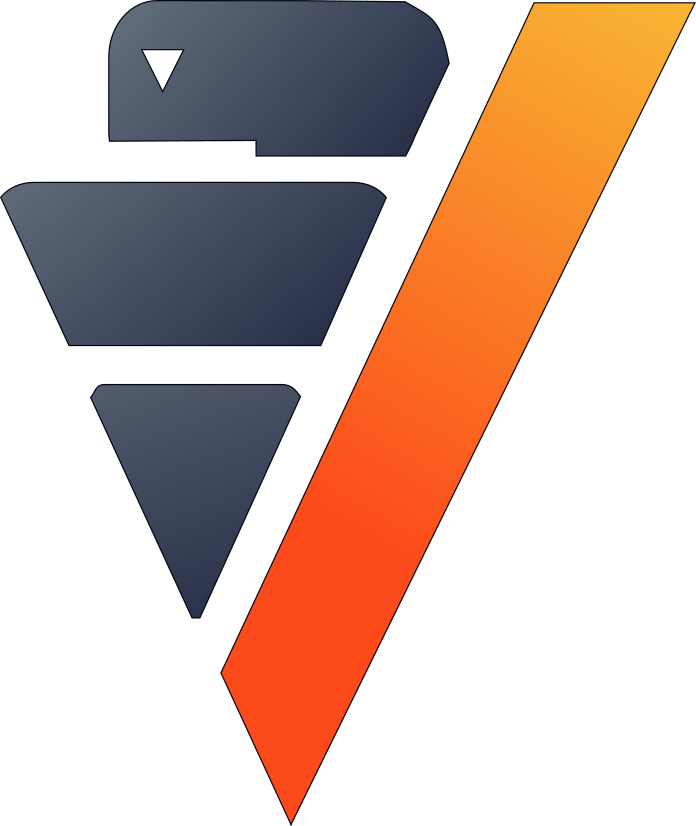

In [21]:
vdf.filter("boat IS NOT NULL")

## 9. Filter unneeded columns

Again, you should always try to cut down your dataset to the essential columns, but writing an explicit command to exclude columns can be cumbersome. Another way to do this is by simply dropping the columns with the 'drop' method.

None   pclass    survived       sex     age    sibsp   \\
1           1           0      male    36.0        0   \\
2           1           0      male    None        0   \\
3           1           1    female    29.0        0   \\
4           1           1      male    0.92        1   \\
5           1           1      male    48.0        0   \\
6           1           1    female    63.0        1   \\
7           1           1    female    53.0        2   \\
8           1           1    female    18.0        1   \\
9           1           1    female    24.0        0   \\
10          1           1      male    80.0        0   \\
11          1           1    female    50.0        0   \\
12          1           1    female    32.0        0   \\
13          1           1      male    37.0        1   \\
14          1           1    female    47.0        1   \\
15          1           1      male    26.0        0   \\
16          1           1    female    42.0        0   \\
17          1           1    female    29.0        0   \\
18          1           1      male    25.0        1   \\
19          1           1    female    19.0        1   \\
20          1           1    female    35.0        0   \\
21          1           1      male    28.0        0   \\
22          1           1      male    40.0        0   \\
23          1           1    female    30.0        0   \\
24          1           1    female    58.0        0   \\
25          1           1    female    45.0        0   \\
26          1           1    female    22.0        0   \\
27          1           1    female    44.0        0   \\
28          1           1    female    59.0        2   \\
29          1           1    female    60.0        0   \\
30          1           1    female    41.0        0   \\
31          1           1      male    42.0        0   \\
32          1           1    female    53.0        0   \\
33          1           1      male    36.0        0   \\
34          1           1    female    58.0        0   \\
35          1           1      male    11.0        1   \\
36          1           1    female    14.0        1   \\
37          1           1      male    36.0        1   \\
38          1           1    female    36.0        1   \\
39          1           1    female    None        0   \\
40          1           1    female    76.0        1   \\
41          1           1    female    47.0        1   \\
42          1           1      male    27.0        1   \\
43          1           1    female    33.0        1   \\
44          1           1    female    36.0        0   \\
45          1           1    female    30.0        0   \\
46          1           1      male    45.0        0   \\
47          1           1    female    None        0   \\
48          1           1    female    26.0        1   \\
49          1           1    female    22.0        0   \\
50          1           1    female    39.0        1   \\
51          1           1    female    64.0        0   \\
52          1           1    female    55.0        2   \\
53          1           1    female    36.0        0   \\
54          1           1    female    64.0        1   \\
55          1           1    female    38.0        1   \\
56          1           1      male    51.0        0   \\
57          1           1      male    27.0        0   \\
58          1           1    female    33.0        0   \\
59          1           1    female    27.0        1   \\
60          1           1      male    31.0        1   \\
61          1           1    female    17.0        1   \\
62          1           1      male    53.0        1   \\
63          1           1      male     4.0        0   \\
64          1           1    female    54.0        1   \\
65          1           1    female    27.0        1   \\
66          1           1    female    48.0        1   \\
67          1           1    female    23.0        0   \\
68          1           1    female    38.0        0   \
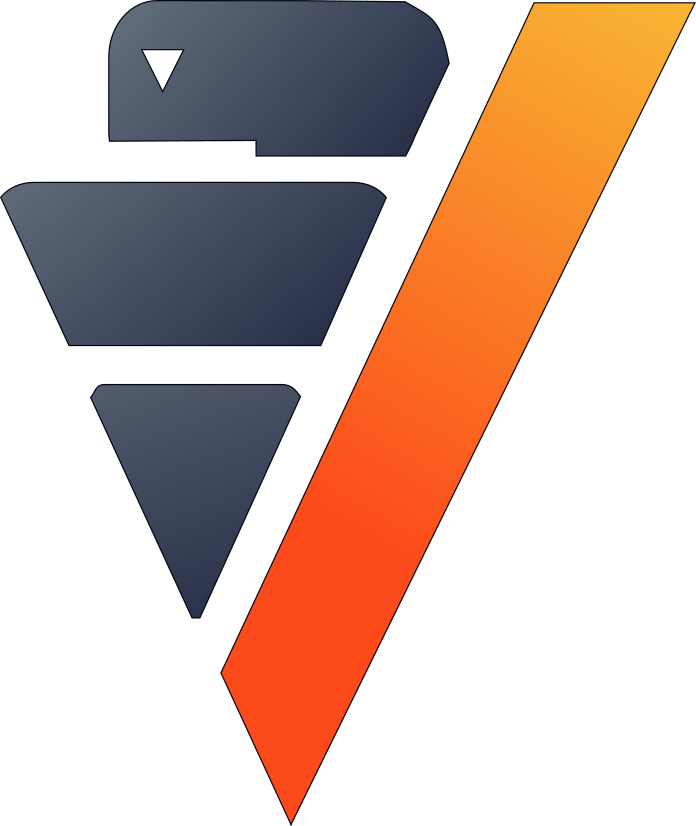

In [22]:
vdf.drop(["name", "body"])

By using the 'drop' method, VerticaPy will simply exclude the specified columns from the SELECT query during SQL code generation.

In [23]:
print(vdf.current_relation())

(
   SELECT
     * 
   FROM
 (
                
   SELECT
     
                    "pclass",
     "survived",
     "sex",
     "age",
     "sibsp",
     "parch",
     "ticket",
     "fare",
     "cabin",
     "embarked",
     "boat",
     "home.dest" 
                
   FROM
 "public"."titanic") 
VERTICAPY_SUBTABLE WHERE (boat IS NOT NULL)) 
VERTICAPY_SUBTABLE


## 10. Maximize your ressources

You might encounter datasets with hundreds of columns. These datasets can be resource intensive because you have to compute many aggregations at the same time. VerticaPy allows you to control the number of queries you'll send to the system, allowing for some useful optimizations.

Let's generate a large dataset and see what we can do to handle it.

None                     x0                     x1                    x2   \\
1      0.000196002889424562      0.223276673816144     0.569054801017046   \\
2      0.000349357724189758      0.373498801840469     0.455233322223648   \\
3      0.000397471478208899      0.541172124678269    0.0819042101502419   \\
4      0.000591944437474012      0.184637373546138     0.677951882593334   \\
5      0.000617067096754909      0.105564348399639     0.584340079687536   \\
6      0.000890686409547925    0.00038997340016067    0.0188652069773525   \\
7      0.000991096021607518      0.318886847002432     0.945748614147305   \\
8       0.00111221522092819      0.127737686270848     0.988597585819662   \\
9       0.00113832904025912      0.514727840432897     0.559510929044336   \\
10      0.00114109506830573       0.16232419735752     0.217413087841123   \\
11      0.00119428080506623      0.306573558831587     0.838272779481485   \\
12      0.00122536788694561      0.579746319213882     0.933371012099087   \\
13      0.00136951776221395     0.0201546978205442     0.129429165739566   \\
14      0.00165392993949354     0.0457139473874122     0.712447781348601   \\
15      0.00177175248973072      0.604761690599844     0.929906299337745   \\
16      0.00177564076147974      0.633743058890104     0.886389599880204   \\
17      0.00179437827318907      0.031732025789097     0.417855974519625   \\
18      0.00188526278361678       0.14518887270242     0.339498677290976   \\
19      0.00198046793229878      0.324288601987064     0.125945880077779   \\
20      0.00202968716621399      0.912033227039501     0.329776650760323   \\
21      0.00204634154215455      0.891580006573349     0.900445770705119   \\
22      0.00231135776266456      0.586080883163959     0.448431284399703   \\
23      0.00241533271037042      0.950201420579106     0.246171033242717   \\
24      0.00258744740858674      0.480214555282146     0.079791471362114   \\
25      0.00260953628458083      0.515196513850242     0.493500957032666   \\
26      0.00281159835867584      0.412008366780356     0.591838584979996   \\
27      0.00319305341690779      0.686583200003952     0.199431726243347   \\
28      0.00335219013504684      0.419994586613029      0.37197250733152   \\
29      0.00341398362070322      0.335965197533369     0.183417018735781   \\
30      0.00342000578530133       0.93244459759444     0.436172142159194   \\
31      0.00350924069061875      0.292276572436094     0.269050881499425   \\
32      0.00361996050924063       0.14558528829366     0.306371202459559   \\
33      0.00370923732407391      0.573737221071497     0.160288677550852   \\
34      0.00380740850232542      0.770958041306585    0.0461475411430001   \\
35      0.00390518456697464      0.575697047170252     0.875962433870882   \\
36      0.00391950504854321      0.282412515720353     0.695511382538825   \\
37      0.00406402605585754       0.85735030984506     0.427328626392409   \\
38      0.00408958340995014      0.363050307380036     0.157119367504492   \\
39      0.00415033474564552      0.698198711965233     0.679820474702865   \\
40      0.00416413717903197      0.960440105292946     0.672868083696812   \\
41       0.0042031176853925      0.465196923352778     0.181161923334002   \\
42      0.00426248111762106      0.730509930290282     0.643103737849742   \\
43      0.00434434111230075      0.200303378747776      0.80254865414463   \\
44      0.00458931573666632      0.650422582868487     0.890518024098128   \\
45      0.00470527354627848       0.76991076557897     0.479205048410222   \\
46      0.00484075397253036     0.0567667258437723     0.746298656798899   \\
47      0.00494534475728869      0.295329740270972     0.987047215923667   \\
48      0.00508410064503551     0.0672630732879043     0.628937016706914   \\
49      0.00513449357822537      0.721188673749566     0.437197042396292   \\
50      0.00515253958292305      0.438512456370518    0.0156327255535871   \\
51      0.005232316907
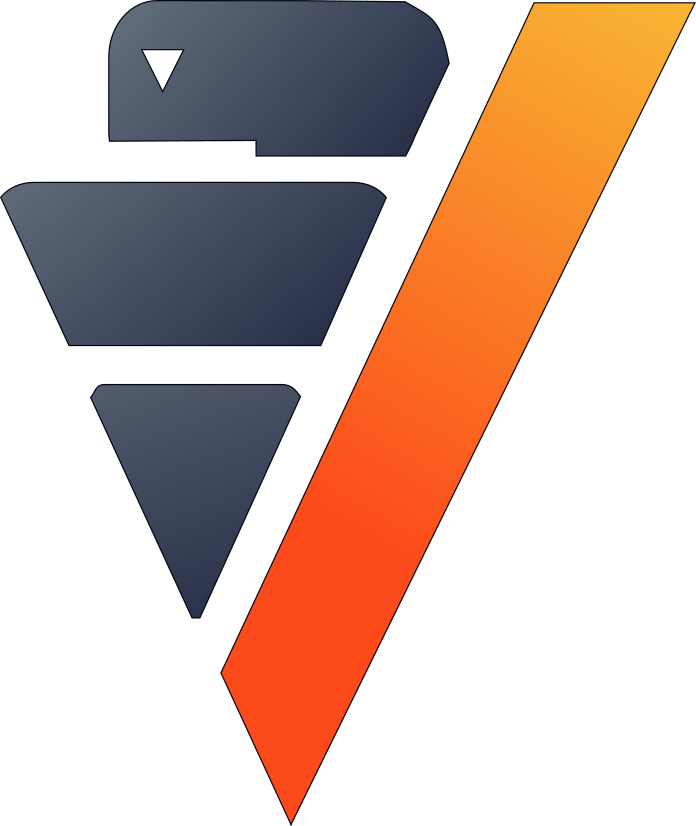

In [24]:
from verticapy.datasets import gen_dataset
features_ranges = {}
for i in range(600):
    features_ranges[f"x{i}"] = {"type": float, "range": [0, 1]}
vp.drop("test_dataset", method = "table")
vdf = gen_dataset(features_ranges, nrows = 10000).to_db("test_dataset", 
                                                        relation_type = "table", 
                                                        inplace = True)
vdf

To see what is happening when you compute aggregations, turn on the SQL code generation and turn off the cache.

In [25]:
vp.set_option("sql_on", True)
vp.set_option("cache", False)

When you compute aggregations, VerticaPy allows you to send multiple queries iteratively or at the same time. To see this in action, let's compute the average of each dataset column. 

You can see that sending one big query is quite resource expensive:

None                      avg  
"x0"        0.504701972361747  
"x1"        0.501500424734084  
"x2"        0.496360847263644  
"x3"        0.501922676050873  
"x4"        0.501098696065019  
"x5"        0.501922402327834  
"x6"        0.497511838229094  
"x7"          0.4995424558128  
"x8"        0.501139220085368  
"x9"        0.498195640844759  
"x10"       0.497437360684294  
"x11"       0.500142348449049  
"x12"       0.499222226529825  
"x13"       0.498205602839845  
"x14"       0.498762407356594  
"x15"       0.501000142000406  
"x16"       0.501418701051641  
"x17"       0.498541878465586  
"x18"       0.498086790131358  
"x19"       0.499275864592963  
"x20"       0.504343404574087  
"x21"       0.501267841389403  
"x22"       0.500294337641075  
"x23"       0.498609771575546  
"x24"        0.49513039909217  
"x25"       0.497790309161809  
"x26"       0.499837644195533  
"x27"       0.506772450118372  
"x28"       0.499061326693045  
"x29"         0.4993529096385  
"x30"       0.495374088925682  
"x31"       0.502070640307362  
"x32"       0.505095819061086  
"x33"       0.502990365797654  
"x34"       0.498580179715413  
"x35"       0.500602371097473  
"x36"       0.498258492268319  
"x37"       0.499188534829393  
"x38"       0.504168833399517  
"x39"       0.504515606336761  
"x40"       0.502317121237377  
"x41"       0.498653725493886  
"x42"       0.501754638836463  
"x43"       0.498120690324809  
"x44"         0.5019756964128  
"x45"       0.500738539828919  
"x46"       0.500888833732437  
"x47"       0.496883777272003  
"x48"       0.501770133955567  
"x49"       0.503218430049461  
"x50"       0.498509138201596  
"x51"       0.495244858069113  
"x52"        0.50525530910485  
"x53"       0.497083567924821  
"x54"       0.500455273832637  
"x55"       0.499142845662287  
"x56"       0.496868709186884  
"x57"       0.499001813516091  
"x58"       0.495315716791851  
"x59"       0.501016464304947  
"x60"       0.502829650190566  
"x61"       0.498022099557892  
"x62"       0.496642323249555  
"x63"       0.504660777674732  
"x64"       0.501959337254707  
"x65"       0.494235374400322  
"x66"        0.50059890185385  
"x67"       0.496015636725887  
"x68"       0.500503553432575  
"x69"       0.502516364711686  
"x70"       0.499548130997946  
"x71"       0.499646790801152  
"x72"       0.497264162153169  
"x73"       0.500046968735894  
"x74"       0.501421513396781  
"x75"       0.504314754247433  
"x76"       0.503196697617904  
"x77"       0.500088797346433  
"x78"       0.501482217736472  
"x79"       0.496628730396088  
"x80"       0.503849816050776  
"x81"        0.49893517983288  
"x82"       0.501510363550577  
"x83"       0.497473525364976  
"x84"       0.498711912596435  
"x85"       0.496939281641785  
"x86"       0.503116286870092  
"x87"       0.497239805244282  
"x88"       0.503653906975943  
"x89"       0.499247443889757  
"x90"       0.498652735777013  
"x91"       0.498757896480709  
"x92"       0.496551240538829  
"x93"       0.498477036886639  
"x94"       0.499959477855195  
"x95"       0.497209327036981  
"x96"       0.501716445775912  
"x97"       0.499029937343462  
"x98"       0.504192987554008  
"x99"       0.501031375516322  
"x100"      0.498165554380533  
"x101"      0.497925305230217  
"x102"      0.501156409019162  
"x103"       0.50097329064589  
"x104"      0.501935073072463  
"x105"      0.500841627669963  
"x106"       0.49827418426685  
"x107"      0.500128609542758  
"x108"      0.499490696650464  
"x109"      0.502856600240269  
"x110"      0.507215060491487  
"x111"      0.504327117043571  
"x112"      0.498356967795664  
"x113"      0.498295797165786  
"x114"      0.499794622069644  
"x115"      0.501494971442176  
"x116"      0.499510358891869  
"x117"      0.500758389808075  
"x118"      0.497459083450725  
"x119"      0.496462270507845  
"x120"      0.499058034386951  
"x121"       0.50388608340635  
"x122"      0.502595011760225  
"x123"      0.503348681323882  

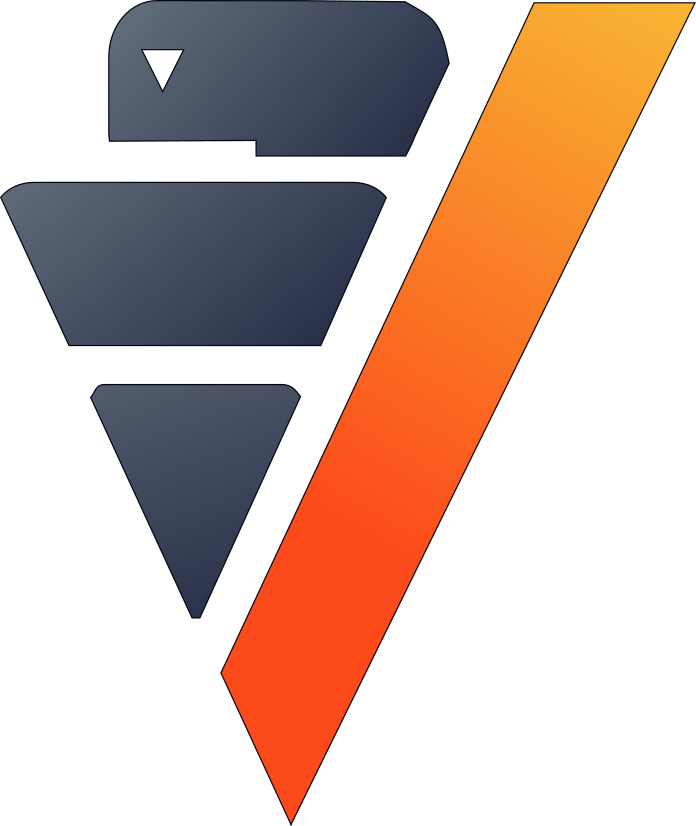

In [26]:
display(vdf.avg(ncols_block = 600))

By using blocks of 100 columns, you reduce your impact on the system.

  0%|          | 0/6 [00:00<?, ?it/s]

None                      avg  
"x0"        0.504701972361747  
"x1"        0.501500424734084  
"x2"        0.496360847263644  
"x3"        0.501922676050873  
"x4"        0.501098696065019  
"x5"        0.501922402327834  
"x6"        0.497511838229094  
"x7"          0.4995424558128  
"x8"        0.501139220085368  
"x9"        0.498195640844759  
"x10"       0.497437360684294  
"x11"       0.500142348449049  
"x12"       0.499222226529825  
"x13"       0.498205602839845  
"x14"       0.498762407356594  
"x15"       0.501000142000406  
"x16"       0.501418701051641  
"x17"       0.498541878465586  
"x18"       0.498086790131358  
"x19"       0.499275864592963  
"x20"       0.504343404574087  
"x21"       0.501267841389403  
"x22"       0.500294337641075  
"x23"       0.498609771575546  
"x24"        0.49513039909217  
"x25"       0.497790309161809  
"x26"       0.499837644195533  
"x27"       0.506772450118372  
"x28"       0.499061326693045  
"x29"         0.4993529096385  
"x30"       0.495374088925682  
"x31"       0.502070640307362  
"x32"       0.505095819061086  
"x33"       0.502990365797654  
"x34"       0.498580179715413  
"x35"       0.500602371097473  
"x36"       0.498258492268319  
"x37"       0.499188534829393  
"x38"       0.504168833399517  
"x39"       0.504515606336761  
"x40"       0.502317121237377  
"x41"       0.498653725493886  
"x42"       0.501754638836463  
"x43"       0.498120690324809  
"x44"         0.5019756964128  
"x45"       0.500738539828919  
"x46"       0.500888833732437  
"x47"       0.496883777272003  
"x48"       0.501770133955567  
"x49"       0.503218430049461  
"x50"       0.498509138201596  
"x51"       0.495244858069113  
"x52"        0.50525530910485  
"x53"       0.497083567924821  
"x54"       0.500455273832637  
"x55"       0.499142845662287  
"x56"       0.496868709186884  
"x57"       0.499001813516091  
"x58"       0.495315716791851  
"x59"       0.501016464304947  
"x60"       0.502829650190566  
"x61"       0.498022099557892  
"x62"       0.496642323249555  
"x63"       0.504660777674732  
"x64"       0.501959337254707  
"x65"       0.494235374400322  
"x66"        0.50059890185385  
"x67"       0.496015636725887  
"x68"       0.500503553432575  
"x69"       0.502516364711686  
"x70"       0.499548130997946  
"x71"       0.499646790801152  
"x72"       0.497264162153169  
"x73"       0.500046968735894  
"x74"       0.501421513396781  
"x75"       0.504314754247433  
"x76"       0.503196697617904  
"x77"       0.500088797346433  
"x78"       0.501482217736472  
"x79"       0.496628730396088  
"x80"       0.503849816050776  
"x81"        0.49893517983288  
"x82"       0.501510363550577  
"x83"       0.497473525364976  
"x84"       0.498711912596435  
"x85"       0.496939281641785  
"x86"       0.503116286870092  
"x87"       0.497239805244282  
"x88"       0.503653906975943  
"x89"       0.499247443889757  
"x90"       0.498652735777013  
"x91"       0.498757896480709  
"x92"       0.496551240538829  
"x93"       0.498477036886639  
"x94"       0.499959477855195  
"x95"       0.497209327036981  
"x96"       0.501716445775912  
"x97"       0.499029937343462  
"x98"       0.504192987554008  
"x99"       0.501031375516322  
"x100"      0.498165554380533  
"x101"      0.497925305230217  
"x102"      0.501156409019162  
"x103"       0.50097329064589  
"x104"      0.501935073072463  
"x105"      0.500841627669963  
"x106"       0.49827418426685  
"x107"      0.500128609542758  
"x108"      0.499490696650464  
"x109"      0.502856600240269  
"x110"      0.507215060491487  
"x111"      0.504327117043571  
"x112"      0.498356967795664  
"x113"      0.498295797165786  
"x114"      0.499794622069644  
"x115"      0.501494971442176  
"x116"      0.499510358891869  
"x117"      0.500758389808075  
"x118"      0.497459083450725  
"x119"      0.496462270507845  
"x120"      0.499058034386951  
"x121"       0.50388608340635  
"x122"      0.502595011760225  
"x123"      0.503348681323882  

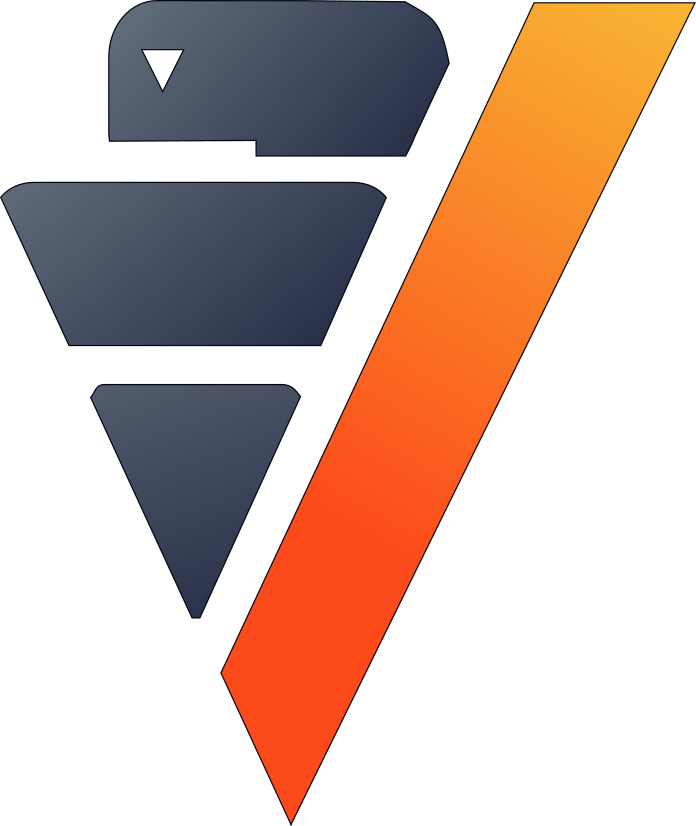

In [27]:
display(vdf.avg(ncols_block = 100))

You can also send multiple queries at the same time. To do this, you specify the number of 'processes', which can be understood as the number of workers involved in the computation. Each child process will create a DB connection and send its query. In the following example, we will use 6 'processes'.

None                      avg  
"x0"        0.500139651982998  
"x1"        0.501554523924948  
"x2"        0.501206196407368  
"x3"        0.500016289698682  
"x4"        0.504199397301208  
"x5"        0.498168718028883  
"x6"        0.500166695084632  
"x7"        0.500573250358412  
"x8"        0.498125163944671  
"x9"        0.500822512500989  
"x10"        0.50523943709312  
"x11"       0.498804886259045  
"x12"        0.50209747372563  
"x13"       0.503426949946955  
"x14"       0.500441713705263  
"x15"        0.50015896079489  
"x16"       0.504339260820905  
"x17"       0.501207838515425  
"x18"       0.499715320018376  
"x19"       0.502836327980366  
"x20"        0.49756880555579  
"x21"       0.498605752931768  
"x22"       0.501371866111481  
"x23"       0.500303264767118  
"x24"       0.502881760140043  
"x25"       0.501360104931076  
"x26"       0.500456427134317  
"x27"       0.497071183138178  
"x28"       0.504468799492344  
"x29"       0.499966012377664  
"x30"       0.496199372792291  
"x31"       0.496457496322808  
"x32"       0.499982719182177  
"x33"       0.502609884057427  
"x34"       0.498528890802944  
"x35"       0.506082921488234  
"x36"       0.502640640748525  
"x37"       0.497638056019438  
"x38"       0.496200608495204  
"x39"       0.501513393113087  
"x40"       0.500217297335481  
"x41"       0.499348560655816  
"x42"       0.502124946557987  
"x43"       0.495808936908189  
"x44"       0.499081352574262  
"x45"        0.50202050736323  
"x46"       0.498471762159164  
"x47"       0.501635447642184  
"x48"       0.502643020480196  
"x49"       0.493976346516889  
"x50"       0.498328662436968  
"x51"       0.502280778884166  
"x52"       0.498583983804961  
"x53"       0.499094679494668  
"x54"        0.49843596059815  
"x55"       0.497868800536124  
"x56"       0.500349338868121  
"x57"       0.503760369799775  
"x58"       0.497272094906098  
"x59"       0.498792519758549  
"x60"       0.497927565051406  
"x61"       0.499857297762111  
"x62"       0.498165683425171  
"x63"       0.507336094678869  
"x64"       0.499731166378851  
"x65"       0.501038957904023  
"x66"       0.496393052230589  
"x67"       0.502572680255421  
"x68"       0.503573072801228  
"x69"       0.505467382855946  
"x70"        0.50093526230345  
"x71"       0.502722916522413  
"x72"       0.498105299516814  
"x73"       0.498870111963269  
"x74"       0.498760579809849  
"x75"       0.498864410239039  
"x76"       0.498901703678607  
"x77"        0.50109361028045  
"x78"       0.500974719111715  
"x79"       0.499533560236823  
"x80"       0.501769229660556  
"x81"       0.504000212397054  
"x82"       0.498394233952463  
"x83"       0.495482387987059  
"x84"        0.50064918404785  
"x85"       0.499818447658769  
"x86"       0.500615357265738  
"x87"       0.499335648885486  
"x88"       0.497822443169053  
"x89"       0.499703504227684  
"x90"       0.500842762801074  
"x91"       0.506645273980685  
"x92"       0.499027101926832  
"x93"       0.500785131426807  
"x94"       0.498635336993006  
"x95"       0.503822560903174  
"x96"       0.497897263612039  
"x97"       0.498652119085798  
"x98"       0.499279668530962  
"x99"       0.500967193495017  
"x100"      0.502578192919306  
"x101"      0.500528614203306  
"x102"       0.49923298501533  
"x103"      0.501318527155626  
"x104"      0.502554105260433  
"x105"      0.502307755408133  
"x106"      0.500070228113024  
"x107"      0.499847287910199  
"x108"      0.503257519891718  
"x109"       0.49995767112847  
"x110"       0.50155360381247  
"x111"      0.500090872106468  
"x112"       0.50309488509458  
"x113"      0.506526694536349  
"x114"      0.500038016738975  
"x115"      0.501390096379374  
"x116"      0.501514889061986  
"x117"      0.500588857951574  
"x118"      0.495587719383347  
"x119"       0.50214116752944  
"x120"      0.498530401867558  
"x121"      0.500338411029009  
"x122"      0.498557904746523  
"x123"      0.497454976699408  

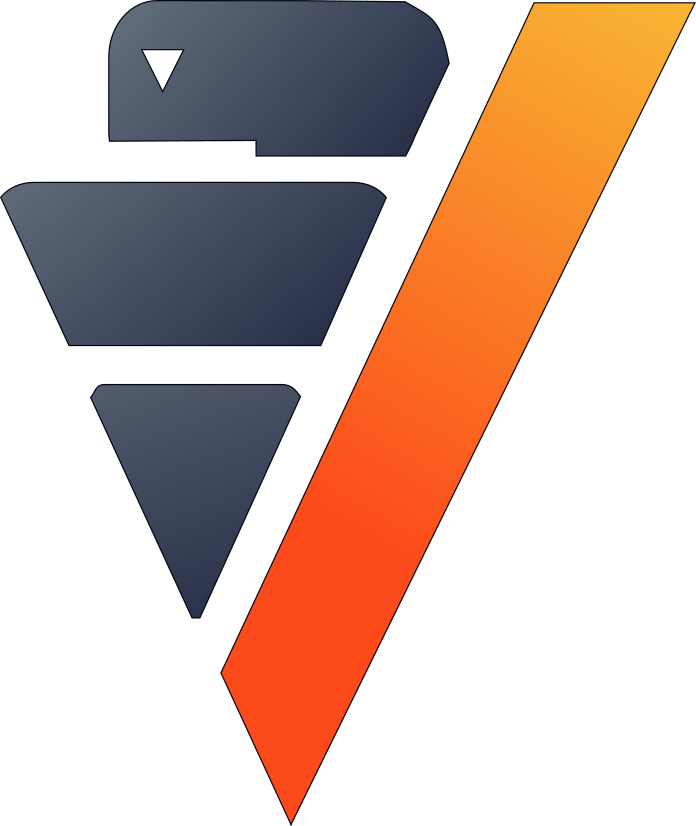

In [28]:
display(vdf.avg(ncols_block = 100, processes = 6))

You should always measure the impact you'll have on the system. Sometimes it is better to send multiple queries iteratively or in parallel rather than one big query. The optimal method depends on the use-case.